# Chess Winner Prediction Using ML Models 

The goal is to predict chess matches winner using the available data from lichess dataset. And also, what is the impact of the opening (strategy and turns taken) in winning the game. You can inspect and download the dataset from [this url](https://www.kaggle.com/datasets/datasnaek/chess).

**TODO: Improve introduction**

**TODO: understand scikit-learn pipelines. [ref_1](https://scikit-learn.org/stable/modules/compose.html#pipeline), [ref_2](https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9)**

## About Dataset

Extracted from official dataset index.

**General Info**

This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org, and how to collect more. This set contains the following features:


- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, [list here](https://www.365chess.com/eco.php));
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

Data was collected using the [Lichess API](https://github.com/ornicar/lila), which enables collection of any given users game history.

**Possible Uses**

Lots of information is contained within a single chess game, let alone a full dataset of multiple games. It is primarily a game of patterns, and data science is all about detecting patterns in data, which is why chess has been one of the most invested in areas of AI in the past. This dataset collects all of the information available from 20,000 games and presents it in a format that is easy to process for analysis of, for example, what allows a player to win as black or white, how much meta (out-of-game) factors affect a game, the relationship between openings and victory for black and white and more.

## Imports

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# only on notebooks
%matplotlib inline

## Loading, exploring and preprocessing data

In [15]:
chess = pd.read_csv('games.csv')

In [16]:
chess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


### Dropping unused columns

Some features, like unique match and player's IDs, if match was rated or not, and timestamps are not useful to us. Therefore, they must be removed. Also, moves can result in some sort of data leakage, therefore will be removed aswell.

In [17]:
chess = chess.drop(['id', 'rated', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_name', 'moves'], axis=1)
chess.head()

,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply
0,13,outoftime,white,1500,1191,D10,5
1,16,resign,black,1322,1261,B00,4
2,61,mate,white,1496,1500,C20,3
3,61,mate,white,1439,1454,D02,3
4,95,mate,white,1523,1469,C41,5


In [18]:
chess.describe()

,turns,white_rating,black_rating,opening_ply
count,20058.000000,20058.000000,20058.000000,20058.000000
mean,60.465999,1596.631868,1588.831987,4.816981
std,33.570585,291.253376,291.036126,2.797152
min,1.000000,784.000000,789.000000,1.000000
25%,37.000000,1398.000000,1391.000000,3.000000
50%,55.000000,1567.000000,1562.000000,4.000000
75%,79.000000,1793.000000,1784.000000,6.000000
max,349.000000,2700.000000,2723.000000,28.000000


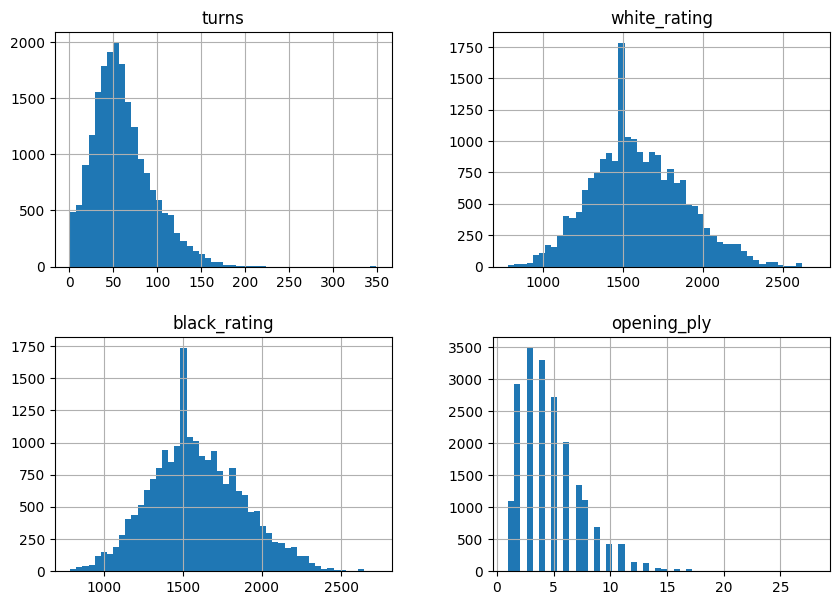

In [19]:
chess.hist(bins=50, figsize=(10,7))
plt.show()

In [20]:
chess['opening_eco'].unique().size

365

### Splitting dataset using holdout method

In [21]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(chess, test_size=0.2, random_state=42)

In [22]:
chess = train_set.copy()

In [23]:
corr_matrix = chess.corr()

In [24]:
corr_matrix['winner'].sort_values(ascending=False)

KeyError: 'winner'